# Conditional Variational AutoEncoder (CVAE) on MNIST data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import tensorflow as tf
import math
from sklearn import model_selection

from keras import layers
from keras import models
from keras import Model
from keras.datasets import mnist
from keras import backend as K
from keras import metrics
from keras import optimizers

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
# The Function used to plot the original image and the predicted image
def Plot_Img(n,k,images,fig_w,fig_h):
    # n is how many digits we will display//
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(k, k))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Data loading and normalization.

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixels to 0 and 1 range
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape each image matrix to a long vector
x_train = np.reshape(x_train, (len(x_train), 28*28))  
x_test = np.reshape(x_test, (len(x_test), 28*28))  
print (x_train.shape)
print (x_test.shape)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 784)
(10000, 784)


Setting up the parameters. Functions for the representation trick and the VAE loss function.

In [0]:
batch_size = 20
input_dim = 28*28
layer_dim = 256
h_dim = 20

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(h_dim,),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

def vae_loss(x, decode_z):
    x = K.flatten(x)
    decode_z = K.flatten(decode_z)
    xent_loss = K.sum(K.binary_crossentropy(x, decode_z), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + vae_log_var - K.square(vae_mu) - K.exp(vae_log_var), axis=-1)
    return xent_loss + kl_loss

##Variational Autoencoder

Main structure of the fully connected VAE model.

In [5]:
# Construct the Fully-Connected VAE model
vae_Input = layers.Input(batch_shape=(batch_size,input_dim,))
vae_f1 = layers.Dense(layer_dim,activation='relu')(vae_Input)
vae_f2 = layers.Dense(layer_dim,activation='relu')(vae_f1)
vae_mu = layers.Dense(h_dim,activation='relu')(vae_f2)
vae_log_var = layers.Dense(h_dim,activation='relu')(vae_f2)

# Imputed latent values
vae_z = layers.Lambda(sampling, output_shape=(h_dim,))([vae_mu, vae_log_var])

# VAE decoder layers
vae_decoder_f1 = layers.Dense(layer_dim,activation='relu')
vae_decoder_f2 = layers.Dense(layer_dim,activation='relu')
vae_decoder_out = layers.Dense(input_dim,activation='sigmoid')

# VAE model
vae_decoder_1 = vae_decoder_f1(vae_z)
vae_decoder_2 = vae_decoder_f2(vae_decoder_1)
vae_decoded = vae_decoder_out(vae_decoder_2)
vae = Model(vae_Input,vae_decoded)
vae.summary()

# The decoder model
vae_z_input = layers.Input(batch_shape=(batch_size,h_dim,))
x = vae_decoder_f1(vae_z_input)
x = vae_decoder_f2(x)
x = vae_decoder_out(x)
vae_decoder = Model(vae_z_input,x)
vae_decoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (20, 784)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (20, 256)            200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (20, 256)            65792       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (20, 20)             5140        dense_2[0][0]                    
_____________________________________

Train the model.

In [6]:
vae_opt = optimizers.Adam(0.0005,0.5)
vae.compile(optimizer=vae_opt, loss=vae_loss)
vae.fit(x_train,x_train,epochs=50,batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
60000/60000 [==============================] - 21s 346us/step - loss: 2980.2915
Epoch 2/50
60000/60000 [==============================] - 19s 321us/step - loss: 2337.8488
Epoch 3/50
60000/60000 [==============================] - 19s 321us/step - loss: 2203.8991
Epoch 4/50
60000/60000 [==============================] - 19s 320us/step - loss: 2132.3633
Epoch 5/50
60000/60000 [==============================] - 19s 321us/step - loss: 2095.7793
Epoch 6/50
60000/60000 [==============================] - 19s 324us/step - loss: 2068.1326
Epoch 7/50
60000/60000 [==============================] - 19s 321us/step - loss: 2045.2004
Epoch 8/50
60000/60000 [==============================] - 19s 323us/step - loss: 2026.6610
Epoch 9/50
60000/60000 [==============================] - 20s 325us/step - loss: 2015.9997
Epoch 10/50
60000/60000 [==============================] - 19s 324us/step - loss: 2005.2642
Epoch 11/50
60000/60000 [================

The example of the reconstructed digits.

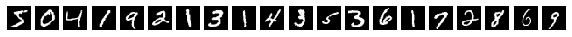

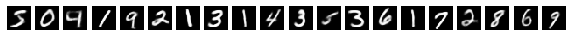

In [7]:
vae_recons = vae.predict(x_train)
Plot_Img(20,28,x_train,10,10)
Plot_Img(20,28,vae_recons,10,10)
plt.show()

Examples of generated digits.

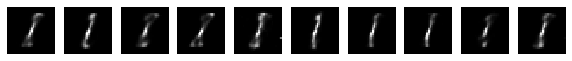

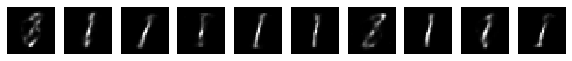

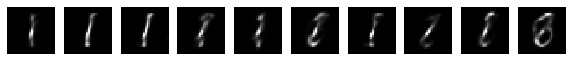

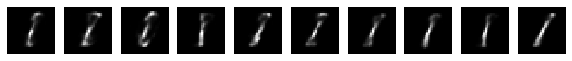

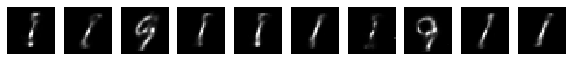

In [24]:
for i in range(5):
    z_sample = np.random.normal(size=(batch_size,h_dim,))
    z_sample = tf.convert_to_tensor(z_sample, dtype=tf.float32)
    Plot_Img(10,28,vae_decoder.predict(z_sample,steps=1),10,10)
plt.show()

# Conditional Variational Autoencoder conditioning on Labels

Transfer all labels to the one-hot vectors.

In [10]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
print(y_train.shape)

(60000, 10)


Parameters, representation trick function and the loss function.

In [0]:
batch_size = 20
input_dim = 28*28
layer_dim = 512
h_dim = 20
cond_dim = y_train.shape[1]

def csampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size,h_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

def cvae_loss(x, decode_z):
    x = K.flatten(x)
    decode_z = K.flatten(decode_z)
    xent_loss = K.sum(K.binary_crossentropy(x, decode_z), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + cvae_log_var - K.square(cvae_mu) - K.exp(cvae_log_var), axis=-1)
    return xent_loss + kl_loss

Main structure of the CVAE model.

In [12]:
# Construct the Fully-Connected CVAE model
X = layers.Input(batch_shape=(batch_size,input_dim))
cond = layers.Input(batch_shape=(batch_size,cond_dim))
cvae_Input = layers.concatenate([X,cond], axis=-1)
cvae_f1 = layers.Dense(layer_dim,activation='relu')(cvae_Input)
cvae_mu = layers.Dense(h_dim,activation='relu')(cvae_f1)
cvae_log_var = layers.Dense(h_dim,activation='relu')(cvae_f1)

# Imputed latent values
cvae_z = layers.Lambda(csampling, output_shape=(h_dim,))([cvae_mu, cvae_log_var])
cvae_z_cond = layers.concatenate([cvae_z,cond], axis=-1)

# CVAE decoder layers
cvae_decoder_f1 = layers.Dense(layer_dim,activation='relu')
cvae_decoder_out = layers.Dense(input_dim,activation='sigmoid')

# CVAE model
cvae_decoder_1 = cvae_decoder_f1(cvae_z_cond)
cvae_decoded = cvae_decoder_out(cvae_decoder_1)
cvae = Model([X,cond],cvae_decoded)
cvae.summary()

# The decoder model
cvae_z_input1 = layers.Input(batch_shape=(batch_size,h_dim))
cvae_z_input2 = layers.Input(batch_shape=(batch_size,cond_dim))
cx = layers.concatenate([cvae_z_input1,cvae_z_input2], axis=-1)
cx = cvae_decoder_f1(cx)
cx = cvae_decoder_out(cx)
cvae_decoder = Model([cvae_z_input1,cvae_z_input2],cx)
cvae_decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (20, 784)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (20, 10)             0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (20, 794)            0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (20, 512)            407040      concatenate_1[0][0]              
__________

Train the CVAE model.

In [13]:
cvae_opt = optimizers.Adam(0.0005,0.5)
cvae.compile(optimizer=cvae_opt, loss=cvae_loss)
cvae.fit([x_train,y_train],x_train,epochs=100,batch_size=batch_size)

Epoch 1/100
60000/60000 [==============================] - 20s 331us/step - loss: 2613.6941
Epoch 2/100
60000/60000 [==============================] - 20s 332us/step - loss: 2124.1228
Epoch 3/100
60000/60000 [==============================] - 20s 326us/step - loss: 2024.4092
Epoch 4/100
60000/60000 [==============================] - 20s 328us/step - loss: 1970.6769
Epoch 5/100
60000/60000 [==============================] - 20s 326us/step - loss: 1937.0308
Epoch 6/100
60000/60000 [==============================] - 19s 324us/step - loss: 1912.9536
Epoch 7/100
60000/60000 [==============================] - 19s 322us/step - loss: 1894.3563
Epoch 8/100
60000/60000 [==============================] - 19s 323us/step - loss: 1881.6548
Epoch 9/100
60000/60000 [==============================] - 19s 323us/step - loss: 1869.2607
Epoch 10/100
60000/60000 [==============================] - 20s 325us/step - loss: 1858.9900
Epoch 11/100
60000/60000 [==============================] - 19s 321us/step - lo

Reconstruction digits sample.

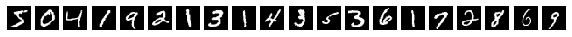

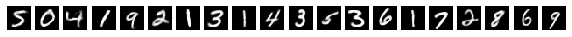

In [26]:
cvae_recons = cvae.predict([x_train,y_train],batch_size=batch_size)
Plot_Img(20,28,x_train,10,10)
Plot_Img(20,28,cvae_recons,10,10)
plt.show()

Generate the digits by controlling the input one-hot vector to produce the specific digit we want.

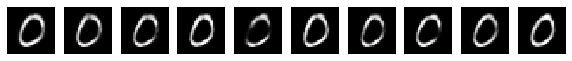

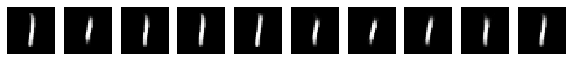

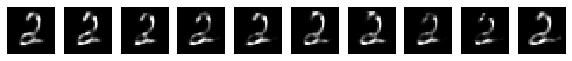

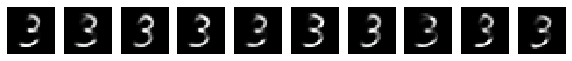

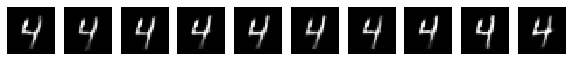

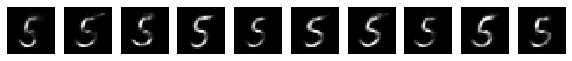

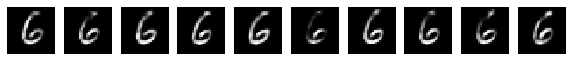

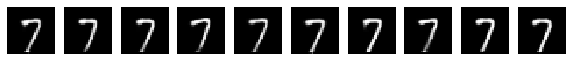

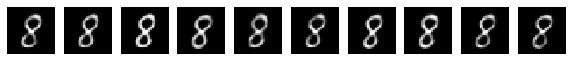

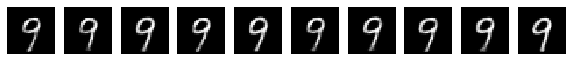

In [18]:
for i in range(10):
    z_sample = np.random.normal(size=(batch_size,h_dim,))
    z_sample = tf.convert_to_tensor(z_sample, dtype=tf.float32)
    cond_sample = np.zeros(shape=(batch_size,10))
    cond_sample[:,i] = 1
    cond_sample = tf.convert_to_tensor(cond_sample, dtype=tf.float32)
    Plot_Img(10,28,cvae_decoder.predict([z_sample,cond_sample],steps=1),10,10)
plt.show()